In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Collect and prepare data for analysis

In [3]:
df = pd.read_csv('C:/Users/dkrre/Downloads/UBER.csv',  parse_dates=True)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df = df[['Close']]  # watch the spaces in the column name 

In [6]:
df

,Close
0,41.570000
1,37.099998
2,39.959999
3,41.290001
4,43.000000
...,...
989,31.480000
990,32.080002
991,31.730000
992,32.040001


In [7]:
df['Close'].isna().sum()

0

In [8]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

994

In [9]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(994, 1)

In [10]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [11]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(990, 1)

In [12]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[43.      , 41.91    , 41.59    , 41.5     , 41.25    , 40.470001,
        41.509998, 40.950001, 39.939999, 39.799999],
       [40.41    , 41.25    , 42.75    , 45.      , 44.919998, 44.16    ,
        42.610001, 42.450001, 42.169998, 44.310001],
       [43.23    , 43.779999, 43.860001, 44.860001, 43.860001, 44.      ,
        43.09    , 43.09    , 42.5     , 45.130001],
       [46.380001, 44.27    , 44.      , 44.23    , 43.529999, 42.950001,
        44.200001, 43.700001, 43.990002, 43.990002],
       [44.529999, 44.130001, 43.619999, 43.709999, 43.18    , 43.689999,
        43.360001, 43.759998, 43.400002, 44.52    ],
       [43.880001, 42.59    , 42.139999, 41.310001, 40.400002, 39.049999,
        39.150002, 39.700001, 42.970001, 40.049999],
       [37.      , 36.450001, 33.959999, 33.220001, 35.23    , 34.610001,
        35.290001, 34.91    , 34.      , 33.43    ],
       [33.310001, 33.110001, 32.59    , 32.759998, 32.57    , 30.700001,
        31.99    , 32.509998, 31.8600

In [13]:
# we can now see that our days have been organized into rows of sequence length. 

In [14]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(69, 9, 1)
(30, 9, 1)


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
3/3 [==============================] - 1s 166ms/step - loss: 1460.9382 - root_mean_squared_error: 38.2222 - val_loss: 1481.4236 - val_root_mean_squared_error: 38.4893
Epoch 2/600
3/3 [==============================] - 0s 70ms/step - loss: 1439.5431 - root_mean_squared_error: 37.9413 - val_loss: 1460.0536 - val_root_mean_squared_error: 38.2106
Epoch 3/600
3/3 [==============================] - 0s 11ms/step - loss: 1418.0321 - root_mean_squared_error: 37.6568 - val_loss: 1435.6350 - val_root_mean_squared_error: 37.8898
Epoch 4/600
3/3 [==============================] - 0s 16ms/step - loss: 1393.2413 - root_mean_squared_error: 37.3261 - val_loss: 1407.0287 - val_root_mean_squared_error: 37.5104
Epoch 5/600
3/3 [==============================] - 0s 16ms/step - loss: 1364.2526 - root_mean_squared_error: 36.9358 - val_loss: 1372.6827 - val_root_mean_squared_error: 37.0497
Epoch 6/600
3/3 [==============================] - 0s 16ms/step - loss: 1329.3809 - root_mean_squared_error: 

3/3 [==============================] - 0s 37ms/step - loss: 560.5825 - root_mean_squared_error: 23.6766 - val_loss: 570.7454 - val_root_mean_squared_error: 23.8903
Epoch 48/600
3/3 [==============================] - 0s 42ms/step - loss: 553.5374 - root_mean_squared_error: 23.5274 - val_loss: 563.7975 - val_root_mean_squared_error: 23.7444
Epoch 49/600
3/3 [==============================] - 0s 39ms/step - loss: 546.8000 - root_mean_squared_error: 23.3838 - val_loss: 557.1115 - val_root_mean_squared_error: 23.6032
Epoch 50/600
3/3 [==============================] - 0s 36ms/step - loss: 540.3123 - root_mean_squared_error: 23.2446 - val_loss: 550.3350 - val_root_mean_squared_error: 23.4592
Epoch 51/600
3/3 [==============================] - 0s 39ms/step - loss: 533.7593 - root_mean_squared_error: 23.1032 - val_loss: 543.6203 - val_root_mean_squared_error: 23.3157
Epoch 52/600
3/3 [==============================] - 0s 38ms/step - loss: 527.2845 - root_mean_squared_error: 22.9627 - val_loss:

3/3 [==============================] - 0s 39ms/step - loss: 316.0219 - root_mean_squared_error: 17.7770 - val_loss: 319.6078 - val_root_mean_squared_error: 17.8776
Epoch 94/600
3/3 [==============================] - 0s 39ms/step - loss: 312.1004 - root_mean_squared_error: 17.6664 - val_loss: 315.5190 - val_root_mean_squared_error: 17.7629
Epoch 95/600
3/3 [==============================] - 0s 47ms/step - loss: 308.2637 - root_mean_squared_error: 17.5574 - val_loss: 311.6596 - val_root_mean_squared_error: 17.6539
Epoch 96/600
3/3 [==============================] - 0s 32ms/step - loss: 304.5484 - root_mean_squared_error: 17.4513 - val_loss: 307.6799 - val_root_mean_squared_error: 17.5408
Epoch 97/600
3/3 [==============================] - 0s 41ms/step - loss: 300.8045 - root_mean_squared_error: 17.3437 - val_loss: 303.7656 - val_root_mean_squared_error: 17.4289
Epoch 98/600
3/3 [==============================] - 0s 47ms/step - loss: 297.0342 - root_mean_squared_error: 17.2347 - val_loss:

3/3 [==============================] - 0s 31ms/step - loss: 186.6744 - root_mean_squared_error: 13.6629 - val_loss: 184.7902 - val_root_mean_squared_error: 13.5938
Epoch 140/600
3/3 [==============================] - 0s 55ms/step - loss: 184.9693 - root_mean_squared_error: 13.6003 - val_loss: 183.0366 - val_root_mean_squared_error: 13.5291
Epoch 141/600
3/3 [==============================] - 0s 39ms/step - loss: 183.3424 - root_mean_squared_error: 13.5404 - val_loss: 181.0909 - val_root_mean_squared_error: 13.4570
Epoch 142/600
3/3 [==============================] - 0s 47ms/step - loss: 181.5121 - root_mean_squared_error: 13.4726 - val_loss: 179.2372 - val_root_mean_squared_error: 13.3879
Epoch 143/600
3/3 [==============================] - 0s 47ms/step - loss: 179.7960 - root_mean_squared_error: 13.4088 - val_loss: 177.4854 - val_root_mean_squared_error: 13.3224
Epoch 144/600
3/3 [==============================] - 0s 39ms/step - loss: 178.1874 - root_mean_squared_error: 13.3487 - val_

3/3 [==============================] - 0s 47ms/step - loss: 118.1204 - root_mean_squared_error: 10.8683 - val_loss: 116.2494 - val_root_mean_squared_error: 10.7819
Epoch 186/600
3/3 [==============================] - 0s 39ms/step - loss: 116.9886 - root_mean_squared_error: 10.8161 - val_loss: 115.1498 - val_root_mean_squared_error: 10.7308
Epoch 187/600
3/3 [==============================] - 0s 39ms/step - loss: 115.8151 - root_mean_squared_error: 10.7617 - val_loss: 114.0851 - val_root_mean_squared_error: 10.6811
Epoch 188/600
3/3 [==============================] - 0s 39ms/step - loss: 114.8008 - root_mean_squared_error: 10.7145 - val_loss: 113.0986 - val_root_mean_squared_error: 10.6348
Epoch 189/600
3/3 [==============================] - 0s 39ms/step - loss: 113.7788 - root_mean_squared_error: 10.6667 - val_loss: 112.1045 - val_root_mean_squared_error: 10.5879
Epoch 190/600
3/3 [==============================] - 0s 33ms/step - loss: 112.8221 - root_mean_squared_error: 10.6218 - val_

Epoch 232/600
3/3 [==============================] - 0s 39ms/step - loss: 79.0411 - root_mean_squared_error: 8.8905 - val_loss: 77.4380 - val_root_mean_squared_error: 8.7999
Epoch 233/600
3/3 [==============================] - 0s 39ms/step - loss: 78.5151 - root_mean_squared_error: 8.8609 - val_loss: 76.5669 - val_root_mean_squared_error: 8.7503
Epoch 234/600
3/3 [==============================] - 0s 37ms/step - loss: 77.8467 - root_mean_squared_error: 8.8231 - val_loss: 75.9834 - val_root_mean_squared_error: 8.7168
Epoch 235/600
3/3 [==============================] - 0s 42ms/step - loss: 77.1670 - root_mean_squared_error: 8.7845 - val_loss: 75.3105 - val_root_mean_squared_error: 8.6782
Epoch 236/600
3/3 [==============================] - 0s 39ms/step - loss: 76.5421 - root_mean_squared_error: 8.7488 - val_loss: 74.5513 - val_root_mean_squared_error: 8.6343
Epoch 237/600
3/3 [==============================] - 0s 44ms/step - loss: 76.0527 - root_mean_squared_error: 8.7208 - val_loss: 73

3/3 [==============================] - 0s 39ms/step - loss: 54.5516 - root_mean_squared_error: 7.3859 - val_loss: 51.8809 - val_root_mean_squared_error: 7.2028
Epoch 280/600
3/3 [==============================] - 0s 32ms/step - loss: 53.9662 - root_mean_squared_error: 7.3462 - val_loss: 51.4921 - val_root_mean_squared_error: 7.1758
Epoch 281/600
3/3 [==============================] - 0s 39ms/step - loss: 53.5662 - root_mean_squared_error: 7.3189 - val_loss: 51.2604 - val_root_mean_squared_error: 7.1596
Epoch 282/600
3/3 [==============================] - 0s 39ms/step - loss: 53.1473 - root_mean_squared_error: 7.2902 - val_loss: 50.6841 - val_root_mean_squared_error: 7.1193
Epoch 283/600
3/3 [==============================] - 0s 47ms/step - loss: 52.8014 - root_mean_squared_error: 7.2665 - val_loss: 50.2955 - val_root_mean_squared_error: 7.0919
Epoch 284/600
3/3 [==============================] - 0s 47ms/step - loss: 52.2850 - root_mean_squared_error: 7.2308 - val_loss: 49.8764 - val_ro

3/3 [==============================] - 0s 32ms/step - loss: 37.8753 - root_mean_squared_error: 6.1543 - val_loss: 35.7184 - val_root_mean_squared_error: 5.9765
Epoch 327/600
3/3 [==============================] - 0s 32ms/step - loss: 37.6512 - root_mean_squared_error: 6.1361 - val_loss: 35.4073 - val_root_mean_squared_error: 5.9504
Epoch 328/600
3/3 [==============================] - 0s 38ms/step - loss: 37.3707 - root_mean_squared_error: 6.1132 - val_loss: 35.1763 - val_root_mean_squared_error: 5.9310
Epoch 329/600
3/3 [==============================] - 0s 39ms/step - loss: 37.0001 - root_mean_squared_error: 6.0828 - val_loss: 34.9483 - val_root_mean_squared_error: 5.9117
Epoch 330/600
3/3 [==============================] - 0s 38ms/step - loss: 36.7403 - root_mean_squared_error: 6.0614 - val_loss: 34.6447 - val_root_mean_squared_error: 5.8860
Epoch 331/600
3/3 [==============================] - 0s 32ms/step - loss: 36.4655 - root_mean_squared_error: 6.0387 - val_loss: 34.5284 - val_ro

3/3 [==============================] - 0s 34ms/step - loss: 27.0808 - root_mean_squared_error: 5.2039 - val_loss: 25.2434 - val_root_mean_squared_error: 5.0243
Epoch 374/600
3/3 [==============================] - 0s 31ms/step - loss: 26.9238 - root_mean_squared_error: 5.1888 - val_loss: 25.3287 - val_root_mean_squared_error: 5.0328
Epoch 375/600
3/3 [==============================] - 0s 32ms/step - loss: 26.8453 - root_mean_squared_error: 5.1812 - val_loss: 25.1057 - val_root_mean_squared_error: 5.0106
Epoch 376/600
3/3 [==============================] - 0s 39ms/step - loss: 26.7360 - root_mean_squared_error: 5.1707 - val_loss: 25.0173 - val_root_mean_squared_error: 5.0017
Epoch 377/600
3/3 [==============================] - 0s 39ms/step - loss: 26.6051 - root_mean_squared_error: 5.1580 - val_loss: 24.7160 - val_root_mean_squared_error: 4.9715
Epoch 378/600
3/3 [==============================] - 0s 32ms/step - loss: 26.3457 - root_mean_squared_error: 5.1328 - val_loss: 24.5946 - val_ro

3/3 [==============================] - 0s 31ms/step - loss: 20.3781 - root_mean_squared_error: 4.5142 - val_loss: 18.3368 - val_root_mean_squared_error: 4.2821
Epoch 421/600
3/3 [==============================] - 0s 39ms/step - loss: 20.2031 - root_mean_squared_error: 4.4948 - val_loss: 18.6764 - val_root_mean_squared_error: 4.3216
Epoch 422/600
3/3 [==============================] - 0s 39ms/step - loss: 20.3471 - root_mean_squared_error: 4.5108 - val_loss: 18.6984 - val_root_mean_squared_error: 4.3242
Epoch 423/600
3/3 [==============================] - 0s 39ms/step - loss: 20.2517 - root_mean_squared_error: 4.5002 - val_loss: 17.7777 - val_root_mean_squared_error: 4.2164
Epoch 424/600
3/3 [==============================] - 0s 32ms/step - loss: 20.0224 - root_mean_squared_error: 4.4746 - val_loss: 17.8023 - val_root_mean_squared_error: 4.2193
Epoch 425/600
3/3 [==============================] - 0s 39ms/step - loss: 19.8831 - root_mean_squared_error: 4.4590 - val_loss: 17.5603 - val_ro

3/3 [==============================] - 0s 35ms/step - loss: 15.6018 - root_mean_squared_error: 3.9499 - val_loss: 13.5225 - val_root_mean_squared_error: 3.6773
Epoch 468/600
3/3 [==============================] - 0s 39ms/step - loss: 15.5480 - root_mean_squared_error: 3.9431 - val_loss: 13.6416 - val_root_mean_squared_error: 3.6935
Epoch 469/600
3/3 [==============================] - 0s 32ms/step - loss: 15.5526 - root_mean_squared_error: 3.9437 - val_loss: 13.4912 - val_root_mean_squared_error: 3.6730
Epoch 470/600
3/3 [==============================] - 0s 39ms/step - loss: 15.4239 - root_mean_squared_error: 3.9273 - val_loss: 13.4724 - val_root_mean_squared_error: 3.6705
Epoch 471/600
3/3 [==============================] - 0s 40ms/step - loss: 15.3664 - root_mean_squared_error: 3.9200 - val_loss: 13.8148 - val_root_mean_squared_error: 3.7168
Epoch 472/600
3/3 [==============================] - 0s 31ms/step - loss: 15.3952 - root_mean_squared_error: 3.9237 - val_loss: 13.1301 - val_ro

3/3 [==============================] - 0s 39ms/step - loss: 12.2677 - root_mean_squared_error: 3.5025 - val_loss: 10.3106 - val_root_mean_squared_error: 3.2110
Epoch 515/600
3/3 [==============================] - 0s 41ms/step - loss: 12.1984 - root_mean_squared_error: 3.4926 - val_loss: 10.3345 - val_root_mean_squared_error: 3.2147
Epoch 516/600
3/3 [==============================] - 0s 32ms/step - loss: 12.2128 - root_mean_squared_error: 3.4947 - val_loss: 10.2774 - val_root_mean_squared_error: 3.2058
Epoch 517/600
3/3 [==============================] - 0s 32ms/step - loss: 12.0811 - root_mean_squared_error: 3.4758 - val_loss: 10.3172 - val_root_mean_squared_error: 3.2120
Epoch 518/600
3/3 [==============================] - 0s 31ms/step - loss: 12.0564 - root_mean_squared_error: 3.4722 - val_loss: 10.4206 - val_root_mean_squared_error: 3.2281
Epoch 519/600
3/3 [==============================] - 0s 32ms/step - loss: 12.0747 - root_mean_squared_error: 3.4749 - val_loss: 10.2633 - val_ro

3/3 [==============================] - 0s 39ms/step - loss: 9.8650 - root_mean_squared_error: 3.1409 - val_loss: 8.1146 - val_root_mean_squared_error: 2.8486
Epoch 562/600
3/3 [==============================] - 0s 32ms/step - loss: 9.8177 - root_mean_squared_error: 3.1333 - val_loss: 8.2755 - val_root_mean_squared_error: 2.8767
Epoch 563/600
3/3 [==============================] - 0s 32ms/step - loss: 9.7679 - root_mean_squared_error: 3.1254 - val_loss: 8.2335 - val_root_mean_squared_error: 2.8694
Epoch 564/600
3/3 [==============================] - 0s 37ms/step - loss: 9.7166 - root_mean_squared_error: 3.1171 - val_loss: 8.2508 - val_root_mean_squared_error: 2.8724
Epoch 565/600
3/3 [==============================] - 0s 39ms/step - loss: 9.7633 - root_mean_squared_error: 3.1246 - val_loss: 7.9325 - val_root_mean_squared_error: 2.8165
Epoch 566/600
3/3 [==============================] - 0s 39ms/step - loss: 9.6231 - root_mean_squared_error: 3.1021 - val_loss: 7.8380 - val_root_mean_squa

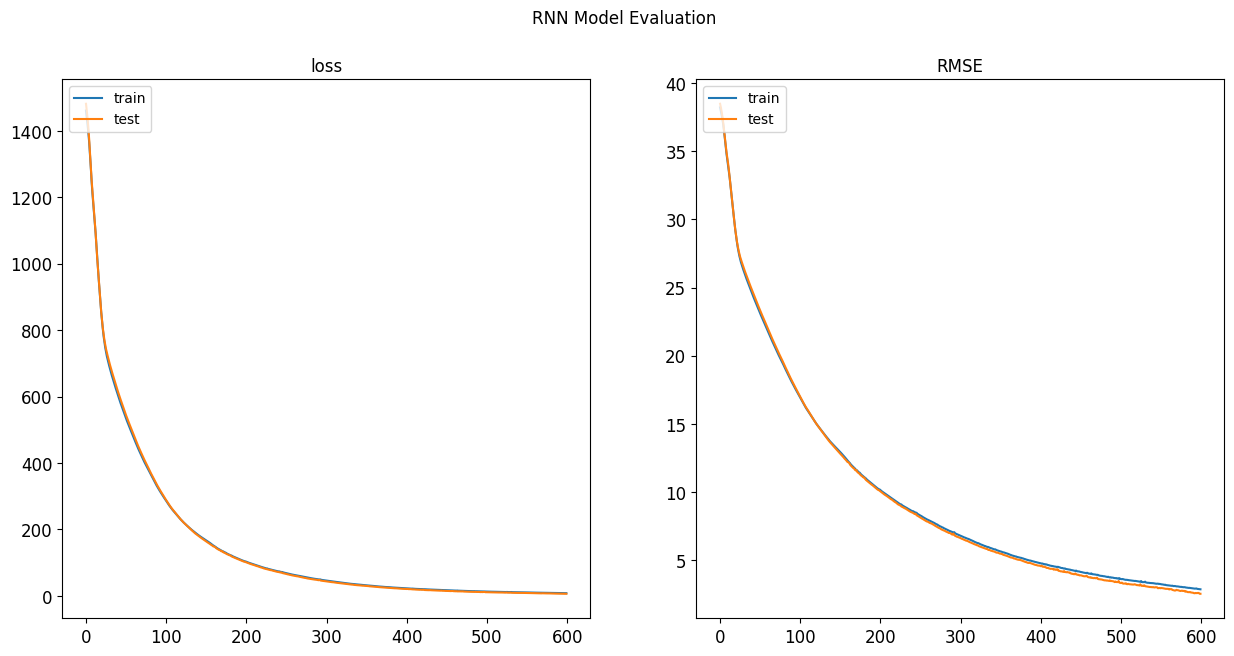

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [21]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 335ms/step


2.5315282739238123

# Neural network

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 8ms/step - loss: 2734.2490
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 2339.2336
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 1988.1274
Epoch 4/100
3/3 [==============================] - 0s 0s/step - loss: 1657.8173
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 1373.8914
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 1113.3103
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 894.9527
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 699.9277
Epoch 9/100
3/3 [==============================] - 0s 0s/step - loss: 536.4289
Epoch 10/100
3/3 [==============================] - 0s 0s/step - loss: 405.7615
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 301.5576
Epoch 12/100
3/3 [==============================] - 0s 10ms/step - loss: 217.2960
Epoch 13/100
3/3 [===============

In [23]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 94ms/step


In [24]:
mean_squared_error(y_test,y_pred)

1.8365248234521794

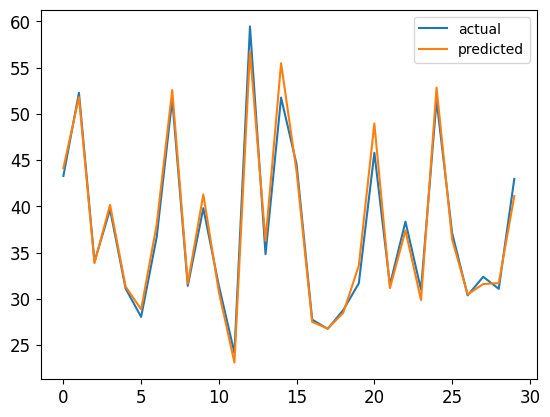

In [25]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [26]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 2s 8ms/step - loss: 1456.9569
Epoch 2/30
3/3 [==============================] - 0s 16ms/step - loss: 1401.4058
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 1344.3649
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 1282.7930
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 1211.2690
Epoch 6/30
3/3 [==============================] - 0s 6ms/step - loss: 1117.2664
Epoch 7/30
3/3 [==============================] - 0s 16ms/step - loss: 979.3500
Epoch 8/30
3/3 [==============================] - 0s 8ms/step - loss: 792.4628
Epoch 9/30
3/3 [==============================] - 0s 8ms/step - loss: 571.3472
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 301.9211
Epoch 11/30
3/3 [==============================] - 0s 8ms/step - loss: 51.3492
Epoch 12/30
3/3 [==============================] - 0s 8ms/step - loss: 77.3842
Epoch 13/30
3/3 [=========================

### Predictions

In [28]:
#Predict:
y_pred = model.predict(X_test)


1/1 [==============================] - 0s 331ms/step


In [29]:
mean_squared_error(y_test,y_pred)

6.830851415511459

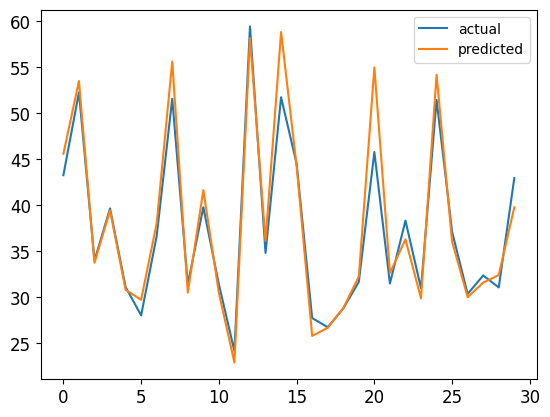

In [30]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')
plt.legend()

plt.show()

# LSTM with more layers

In [31]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 6s 16ms/step - loss: 1421.3999
Epoch 2/30
3/3 [==============================] - 0s 16ms/step - loss: 1406.6461
Epoch 3/30
3/3 [==============================] - 0s 16ms/step - loss: 1391.6039
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 1375.6860
Epoch 5/30
3/3 [==============================] - 0s 16ms/step - loss: 1358.3411
Epoch 6/30
3/3 [==============================] - 0s 24ms/step - loss: 1338.4933
Epoch 7/30
3/3 [==============================] - 0s 16ms/step - loss: 1315.3553
Epoch 8/30
3/3 [==============================] - 0s 23ms/step - loss: 1288.9324
Epoch 9/30
3/3 [==============================] - 0s 19ms/step - loss: 1259.4567
Epoch 10/30
3/3 [==============================] - 0s 23ms/step - loss: 1228.3210
Epoch 11/30
3/3 [==============================] - 0s 16ms/step - loss: 1196.3542
Epoch 12/30
3/3 [==============================] - 0s 16ms/step - loss: 1166.0101
Epoch 13/30
3/3 [========

# Predictions

In [33]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [34]:
mean_squared_error(y_test,y_pred)

847.9293053950398

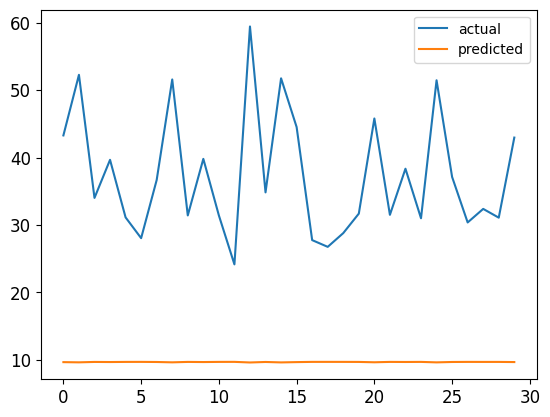

In [35]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')
plt.legend()

plt.show()

# GRU (with more layers)

In [36]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 5s 23ms/step - loss: 1720.9460
Epoch 2/30
3/3 [==============================] - 0s 16ms/step - loss: 1465.1726
Epoch 3/30
3/3 [==============================] - 0s 16ms/step - loss: 1305.1416
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 1124.8322
Epoch 5/30
3/3 [==============================] - 0s 16ms/step - loss: 904.9894
Epoch 6/30
3/3 [==============================] - 0s 16ms/step - loss: 672.2632
Epoch 7/30
3/3 [==============================] - 0s 16ms/step - loss: 369.3577
Epoch 8/30
3/3 [==============================] - 0s 16ms/step - loss: 82.8177
Epoch 9/30
3/3 [==============================] - 0s 16ms/step - loss: 7.1648
Epoch 10/30
3/3 [==============================] - 0s 16ms/step - loss: 7.5466
Epoch 11/30
3/3 [==============================] - 0s 19ms/step - loss: 5.8229
Epoch 12/30
3/3 [==============================] - 0s 32ms/step - loss: 8.4327
Epoch 13/30
3/3 [=========================

# Predictions

In [38]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 597ms/step


In [39]:
mean_squared_error(y_test,y_pred)

5.939318628211981

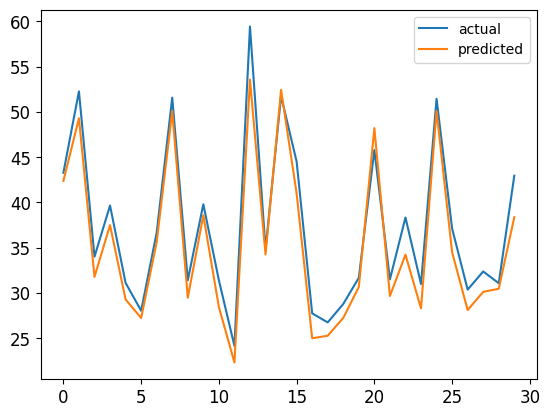

In [40]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')
plt.legend()

plt.show()

# Conv1D

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 5s 229ms/step - loss: 1353.6677
Epoch 2/30
3/3 [==============================] - 0s 142ms/step - loss: 1076.7579
Epoch 3/30
3/3 [==============================] - 1s 180ms/step - loss: 906.0887
Epoch 4/30
3/3 [==============================] - 1s 173ms/step - loss: 730.1536
Epoch 5/30
3/3 [==============================] - 1s 165ms/step - loss: 554.1639
Epoch 6/30
3/3 [==============================] - 1s 212ms/step - loss: 393.7736
Epoch 7/30
3/3 [==============================] - 0s 132ms/step - loss: 246.3069
Epoch 8/30
3/3 [==============================] - 1s 173ms/step - loss: 119.7559
Epoch 9/30
3/3 [==============================] - 1s 173ms/step - loss: 35.6365
Epoch 10/30
3/3 [==============================] - 0s 157ms/step - loss: 5.1859
Epoch 11/30
3/3 [==============================] - 1s 196ms/step - loss: 25.3824
Epoch 12/30
3/3 [==============================] - 0s 149ms/step - loss: 33.2025
Epoch 13/30
3/3 [===========

# Predictions

In [43]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 579ms/step


In [44]:
mean_squared_error(y_test,y_pred)

2.756240809049265

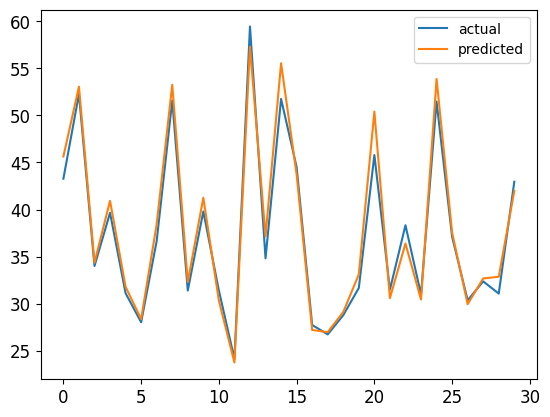

In [45]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')
plt.legend()

plt.show()

Neural networks is the best performing model with mean squared error value 1.8365248234521794.